In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#Expects timeseries.py in same folder as nb. 
from fastai.vision import *
from pathlib import Path
import pdb
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from timeseries import TimeSeriesItem, TimeSeriesList, UCRArchive
from scipy.signal import resample
from IPython.display import clear_output
import fastai.utils.mem

In [3]:
#init UCR archive helper class
ucr = UCRArchive()

In [4]:
#All input is resampled down to a length of 96
class Resample(PreProcessor):
    def process_one(self,item):
        return np.concatenate([item[[0]],resample(item[1:],96)]) if len(item) > 97 else item

In [5]:
#Helper functions, modified to 1d from fastai
def create_head_1d(nf:int, nc:int, lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5, bn_final:bool=False):
    "Model head that takes `nf` features, runs through `lin_ftrs`, and about `nc` classes."
    lin_ftrs = [nf, 512, nc] if lin_ftrs is None else [nf] + lin_ftrs + [nc]
    ps = listify(ps)
    if len(ps)==1: ps = [ps[0]/2] * (len(lin_ftrs)-2) + ps
    actns = [nn.ReLU(inplace=True)] * (len(lin_ftrs)-2) + [None]
    layers = []
    for ni,no,p,actn in zip(lin_ftrs[:-1],lin_ftrs[1:],ps,actns):
        layers += bn_drop_lin(ni,no,True,p,actn)
    if bn_final: layers.append(nn.BatchNorm1d(lin_ftrs[-1], momentum=0.01))
    return nn.Sequential(*layers)

def conv1d(ni:int, nf:int, ks:int=3, stride:int=1, padding:int=None, bias=False, init:LayerFunc=nn.init.kaiming_normal_) -> nn.Conv1d:
    "Create and initialize `nn.Conv1d` layer. `padding` defaults to `ks//2`."
    if padding is None: padding = ks//2
    return init_default(nn.Conv1d(ni, nf, kernel_size=ks, stride=stride, padding=padding, bias=bias), init)

In [6]:
#This is the hero network, which serves as a backbone to all the other models
class HeroConvnet(nn.Module):
    def __init__(self, num_layers=8, start_nf=8):
        super().__init__()
        
        layers = [nn.Sequential(conv1d(1,start_nf,3,1),nn.ReLU())] #First layer is stride 1, creates initial set of filters
        nf = start_nf
        for _ in range(num_layers): #Then num_layers stride 2 convs, doubling the number of filters each layer
            layers.append(nn.Sequential(conv1d(nf,nf*2,3,2),nn.ReLU()))
            nf *= 2
        
        self.nf = nf
        self.layers = nn.ModuleList(layers)
        self.avg = nn.AdaptiveAvgPool1d(1)
            
            
    def forward(self, x):
        actvns = [x]
        
        for l in self.layers:
            actvns.append(l(actvns[-1]))

        return self.avg(actvns[-1]), actvns[1:]

In [7]:
class BasicClassifier(nn.Module):
    def __init__(self,numClasses):
        super().__init__()
        self.conv = HeroConvnet()
        self.out = create_head_1d(self.conv.nf,numClasses,ps=0.0)
              
    def forward(self,ts):
        ts = self.conv(ts.unsqueeze(1))[0].squeeze(-1)
        return self.out(ts)

In [8]:
#Basic variational autoencoder with hero net serving as encoder and a few linear layers as decoder
class TSAutoencoder(nn.Module):
    def __init__(self,seqLen,latentDim=12):
        super().__init__()
        self.conv = HeroConvnet()
        self.mean = torch.nn.Linear(self.conv.nf,latentDim)
        self.logvar = torch.nn.Linear(self.conv.nf,latentDim)
        self.out = create_head_1d(latentDim,seqLen,lin_ftrs=[256,512],ps=0.0)

    def forward(self,ts):
        seqLen = ts.shape[1]
        ts, _ = self.conv(ts.unsqueeze(1))
        ts = ts.squeeze(-1)

        mean, logvar = self.mean(ts), self.logvar(ts)
          
        ls = mean
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            ls = eps.mul(std).add_(mean)        
        return self.out(ls), mean, logvar

In [9]:
#The sidekick network mirrors the structure of the hero, but concats the output of each layer of the hero to the input of each 
#layer of the sidekick
class SidekickConvnet(nn.Module):
    def __init__(self, num_classes, num_layers=8, start_nf=8, start_nf_hero=8):
        super().__init__()
        
        self.hero = HeroConvnet(num_layers,start_nf_hero)
        
        layers = [nn.Sequential(conv1d(1,start_nf,3,1),nn.ReLU())] 
        nf = start_nf
        nf_hero = start_nf_hero
        for _ in range(num_layers):
            layers.append(nn.Sequential(conv1d(nf+nf_hero,nf*2,3,2),nn.ReLU()))
            nf *= 2
            nf_hero *= 2
        
        self.layers = nn.ModuleList(layers)
        self.avg = nn.AdaptiveAvgPool1d(1)
        self.out = create_head_1d(nf + nf_hero,num_classes,ps=0.0)
    
    def forward(self,ts):
        ts = ts.unsqueeze(1)
        pt, actvns = self.hero(ts)
        
        x = self.layers[0](ts)
        for l,a in zip(self.layers[1:],actvns):
            x = l(torch.cat([x,a],dim=1))
            
        x = torch.cat([self.avg(x),pt],dim=1).squeeze(-1)
        return self.out(x)

In [10]:
class VAELoss(torch.nn.Module):
    def __init__(self,beta=1.0):
        super().__init__()
        self.beta = beta
    def forward(self,p,target):
        pred,mean,logvar = p
        self.mse = torch.nn.functional.mse_loss(pred,target,reduction="sum")
        self.kld = self.beta * -0.5 * torch.sum(1+logvar-mean.pow(2)-logvar.exp())
        return self.mse + self.kld

In [11]:
@fastai.utils.mem.gpu_mem_restore
def EvaluateDataset(dataset_name):
    out = [dataset_name]
    
    try:
        src = TimeSeriesList.from_csv_list(ucr.get_csv_files(dataset_name),labelCol=0)#,processor=Resample())
        valIdxs = np.random.choice(len(src.items),int(len(src.items)*0.3),replace=False)
        data = src.split_by_idx(valIdxs)
        data = data.label_from_col()
        idxs = np.random.choice(len(data.x),size=len(data.x)//10,replace=False)
        bs = min(64,len(data.x)//50)
        data.x.items = data.train.x.items[idxs]
        data.y.items = data.train.y.items[idxs]
        data = data.databunch(bs=bs,num_workers=0)

        src = TimeSeriesList.from_csv_list(ucr.get_csv_files(dataset_name),labelCol=0)#,processor=Resample())
        dataAE = src.split_by_idx(valIdxs)
        dataAE = dataAE.label_from_self()
        dataAE = dataAE.databunch(bs=bs,num_workers=0)

        learnBase = Learner(data,BasicClassifier(data.train_ds.c),loss_func=F.cross_entropy,metrics=[accuracy])
        learnBase.fit_one_cycle(20,1e-3,wd=0.2)
        out.append(max([m[0].item() for m in learnBase.recorder.metrics]))

        learnAE = Learner(dataAE,TSAutoencoder(len(data.train_ds[0][0].data),latentDim=12),loss_func=VAELoss())
        learnAE.fit_one_cycle(20,1e-2)
        learnAE.fit_one_cycle(20,1e-3)
        out.append(learnAE.validate(dataAE.train_dl)[0])
        
#         learnSidekick = Learner(data,SidekickConvnet(data.train_ds.c), loss_func=F.cross_entropy,metrics=[accuracy],
#                             callback_fns=BnFreeze,bn_wd=False,train_bn=False)
#         learnSidekick.split([learnSidekick.model.hero,learnSidekick.model.layers[0],learnSidekick.model.out])
#         learnSidekick.model.hero.load_state_dict(learnAE.model.conv.state_dict())
#         learnSidekick.freeze_to(1)
#         learnSidekick.fit_one_cycle(20,1e-3,wd=0.2)
#         learnSidekick.fit_one_cycle(20,1e-4,wd=0.2)
#         out.append(max([m[0].item() for m in learnSidekick.recorder.metrics]))
        
#         learnAE.fit_one_cycle(200,1e-3)
#         out.append(learnAE.validate(dataAE.train_dl)[0])


        learnDT = Learner(data,BasicClassifier(data.train_ds.c),loss_func=F.cross_entropy,metrics=[accuracy],
                     callback_fns=BnFreeze,bn_wd=False,train_bn=False)
        learnDT.split([*learnDT.model.conv.layers,learnDT.model.conv.avg,learnDT.model.out])
        learnDT.model.conv.load_state_dict(learnAE.model.conv.state_dict())
        learnDT.freeze_to(-1)
        learnDT.fit_one_cycle(20,1e-3)
        out.append(max([m[0].item() for m in learnDT.recorder.metrics]))
        learnDT.unfreeze()
        learnDT.fit_one_cycle(100,1e-4)
        out.append(max([m[0].item() for m in learnDT.recorder.metrics]))
        
        learnSidekickBase = Learner(data,SidekickConvnet(data.train_ds.c), loss_func=F.cross_entropy,metrics=[accuracy],
                    callback_fns=BnFreeze,bn_wd=False,train_bn=False)
        learnSidekickBase.fit_one_cycle(20,1e-3,wd=0.2)
        learnSidekickBase.fit_one_cycle(20,1e-4,wd=0.2)
        out.append(max([m[0].item() for m in learnSidekickBase.recorder.metrics]))

        learnSidekick = Learner(data,SidekickConvnet(data.train_ds.c), loss_func=F.cross_entropy,metrics=[accuracy],
                            callback_fns=BnFreeze,bn_wd=False,train_bn=False)
        learnSidekick.split([learnSidekick.model.hero,learnSidekick.model.layers[0],learnSidekick.model.out])
        learnSidekick.model.hero.load_state_dict(learnAE.model.conv.state_dict())
        learnSidekick.freeze_to(1)
        learnSidekick.fit_one_cycle(20,1e-3,wd=0.2)
        learnSidekick.fit_one_cycle(20,1e-4,wd=0.2)
        out.append(max([m[0].item() for m in learnSidekick.recorder.metrics]))
    except:
        pass
    return out

In [12]:
results = []
for _ in range(10): results.append(EvaluateDataset("SyntheticControl"))

epoch,train_loss,valid_loss,accuracy
1,1.880540,1.791182,0.150000
2,1.678885,1.783238,0.322222
3,1.450733,1.758377,0.333333
4,1.282187,1.710459,0.600000
5,1.158320,1.630993,0.594444
6,1.035302,1.502476,0.622222
7,0.953274,1.350184,0.611111
8,0.882002,1.177297,0.600000
9,0.819927,1.033468,0.622222
10,0.782309,0.986858,0.627778


epoch,train_loss,valid_loss,accuracy
1,0.634113,0.807073,0.627778
2,0.613027,0.796553,0.627778
3,0.566280,0.789950,0.627778
4,0.555654,0.787416,0.627778
5,0.549908,0.794275,0.627778
6,0.528039,0.791767,0.627778
7,0.520652,0.784335,0.627778
8,0.516052,0.777569,0.627778
9,0.510765,0.775273,0.627778
10,0.497689,0.778565,0.633333


epoch,train_loss,valid_loss,accuracy
1,1.721731,1.775386,0.244444
2,1.251321,1.697305,0.516667
3,0.937256,1.529989,0.566667
4,0.726607,1.294361,0.600000
5,0.606896,1.055671,0.672222
6,0.504763,0.876308,0.744444
7,0.425172,0.911379,0.700000
8,0.377876,0.798796,0.744444
9,0.340819,0.623505,0.805556
10,0.300917,0.722445,0.750000


epoch,train_loss,valid_loss,accuracy
1,0.030519,0.497059,0.827778
2,0.029557,0.493257,0.827778
3,0.029885,0.501999,0.822222
4,0.039552,0.503610,0.822222
5,0.038154,0.512538,0.822222
6,0.034791,0.506583,0.805556
7,0.034222,0.496763,0.816667
8,0.030634,0.485004,0.822222
9,0.045158,0.527670,0.822222
10,0.043308,0.543388,0.816667


epoch,train_loss,valid_loss,accuracy
1,1.553681,1.791399,0.172222
2,1.109030,1.777391,0.172222
3,0.851356,1.742083,0.172222
4,0.678233,1.680929,0.288889
5,0.555461,1.565308,0.488889
6,0.479164,1.470679,0.600000
7,0.430059,1.274126,0.622222
8,0.468864,1.149801,0.633333
9,0.433094,0.898253,0.700000
10,0.383095,0.771171,0.677778


epoch,train_loss,valid_loss,accuracy
1,0.021044,0.324307,0.883333
2,0.020826,0.324413,0.888889
3,0.040652,0.320356,0.888889
4,0.035480,0.320997,0.883333
5,0.032637,0.337876,0.872222
6,0.039912,0.290978,0.900000
7,0.036668,0.271695,0.894444
8,0.035176,0.252273,0.916667
9,0.031452,0.242379,0.927778
10,0.032297,0.239474,0.927778


In [13]:
df = pd.DataFrame(results,columns=["Name","Baseline","AE","Direct","Fine Tune","SidekickBase","Sidekick"])

In [19]:
df

,Name,Baseline,AE,Direct,Fine Tune,SidekickBase,Sidekick
0,SyntheticControl,0.661111,286.126526,0.766667,0.888889,0.916667,0.805556
1,SyntheticControl,0.877778,290.560974,0.627778,0.811111,0.777778,0.911111
2,SyntheticControl,0.783333,281.490509,0.783333,0.811111,0.744444,0.916667
3,SyntheticControl,0.744444,280.732849,0.822222,0.950000,0.794444,0.905556
4,SyntheticControl,0.688889,278.169891,0.716667,0.844444,0.738889,0.833333
5,SyntheticControl,0.750000,289.481323,0.766667,0.905556,0.855556,0.883333
6,SyntheticControl,0.800000,281.751038,0.672222,0.844444,0.844444,0.794444
7,SyntheticControl,0.733333,274.082001,0.694444,0.822222,0.694444,0.855556
8,SyntheticControl,0.833333,281.962128,0.716667,0.872222,0.733333,0.922222
9,SyntheticControl,0.888889,284.240112,0.627778,0.855556,0.827778,0.927778


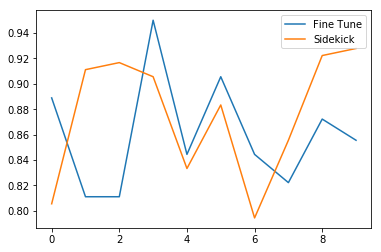

In [18]:
df[["Fine Tune","Sidekick"]].plot()

In [ ]:
df = df.groupby(by="Name").mean().reset_index()

In [17]:
df["Gain"] = df["Sidekick"] - df[["Baseline","SidekickBase"]].max(axis=1)

In [18]:
df["Sidekick Gain"] = df["Sidekick"] - df[["Direct","Fine Tune"]].max(axis=1)

In [ ]:
df.to_csv("results.csv")

In [ ]:
df.to_clipboard()

In [21]:
df.sort_values("Gain",ascending=False)

,Name,Baseline,AE20,Sidekick20,AE200,Direct,Fine Tune,SidekickBase,Sidekick,Gain,Sidekick Gain
107,SyntheticControl,0.783333,275.660461,0.894444,256.649139,0.788889,0.894444,0.755556,0.861111,0.077778,-0.033333
32,FaceAll,0.765926,1310.776611,0.834074,956.164246,0.746667,0.764444,0.789630,0.848889,0.059259,0.084444
78,PhalangesOutlinesCorrect,0.672522,89.742630,0.772898,8876.871094,0.715182,0.720201,0.772898,0.811794,0.038896,0.091593
71,MixedShapesRegularTrain,0.841505,2106.697998,0.860889,1811.907593,0.851767,0.867731,0.838084,0.880274,0.038769,0.012543
85,Plane,0.730159,91.518723,0.746032,91.032608,0.253968,0.301587,0.682540,0.761905,0.031746,0.460317
77,OSULeaf,0.310606,1075.557861,0.363636,697.996399,0.378788,0.393939,0.303030,0.340909,0.030303,-0.053030
72,MixedShapesSmallTrain,0.846764,1964.121704,0.873184,1231.103027,0.889036,0.887715,0.828269,0.871863,0.025099,-0.017173
101,SonyAIBORobotSurface1,0.967742,155.038452,0.989247,107.796333,0.989247,0.983871,0.951613,0.989247,0.021505,0.000000
56,InlineSkate,0.246154,1364.470581,0.241026,735.094849,0.276923,0.276923,0.230769,0.266667,0.020513,-0.010256
36,Fish,0.704762,67.874763,0.685714,73.091316,0.447619,0.495238,0.685714,0.723810,0.019048,0.228571
